In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv("../data/bike_clean_rep.csv")
df.head()

,Unnamed: 0,date,season,holiday,snowfall,rainfall,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rep_count
0,1,2017-12-01,Winter,No Holiday,0,0.0,9539,-1.10,37.5,1.4,20000,-17.40,0.0,677
1,2,2017-12-02,Winter,No Holiday,0,0.0,8523,2.70,55.5,1.6,14410,-5.55,0.0,836
2,3,2017-12-03,Winter,No Holiday,0,4.0,7222,4.35,84.5,1.6,3380,2.65,0.0,999
3,4,2017-12-04,Winter,No Holiday,0,0.1,8729,-0.25,43.5,3.6,19130,-12.95,0.0,744
4,5,2017-12-05,Winter,No Holiday,0,0.0,8307,-3.80,34.5,0.0,20000,-17.70,0.0,638


In [3]:
df1 = df.drop(['Unnamed: 0', 'date'], axis = 1, inplace = False)
df2 = pd.get_dummies(df1, columns=['season', 'holiday'])
df2.head()

,snowfall,rainfall,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rep_count,season_Autumn,season_Spring,season_Summer,season_Winter,holiday_Holiday,holiday_No Holiday
0,0,0.0,9539,-1.10,37.5,1.4,20000,-17.40,0.0,677,0,0,0,1,0,1
1,0,0.0,8523,2.70,55.5,1.6,14410,-5.55,0.0,836,0,0,0,1,0,1
2,0,4.0,7222,4.35,84.5,1.6,3380,2.65,0.0,999,0,0,0,1,0,1
3,0,0.1,8729,-0.25,43.5,3.6,19130,-12.95,0.0,744,0,0,0,1,0,1
4,0,0.0,8307,-3.80,34.5,0.0,20000,-17.70,0.0,638,0,0,0,1,0,1


## Stacked Cross Validation Split

In [4]:
X = df2.drop(['rep_count'], axis = 1, inplace = False).to_numpy()
y = df2.rep_count.to_numpy()

In [58]:
tscv = TimeSeriesSplit(n_splits = 3)
X_train = []
X_test = []
y_train = []
y_test = []
for train_index, test_index in tscv.split(X):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])
input_data = (X_train, y_train, X_test, y_test)

## Function

In [59]:
def train_nth_set(input_data, n = 1, show_summary = False, **kwargs):
    X_train, y_train, X_test, y_test = input_data
    model = keras.Sequential()
    model.add(layers.Dense(16, input_shape = (None, 1)))
    model.add(layers.LSTM(50))
    model.add(layers.Dense(16))
    model.add(layers.Dense(1, activation = "relu"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if show_summary:
        print(model.summary())
    x = tf.convert_to_tensor(X_train[n-1].reshape((-1, 15, 1)), np.float32)
    y = tf.convert_to_tensor(y_train[n-1].reshape(-1, 1, 1), np.float32)
    x_test = tf.convert_to_tensor(X_test[n-1].reshape((-1, 15, 1)), np.float32)
    y_test = tf.convert_to_tensor(y_test[n-1].reshape((-1, 1, 1)), np.float32)
    hist = model.fit(x,y, batch_size = 1, verbose = 0, validation_data = (x_test, y_test), **kwargs)
    return model, hist
def eval_nth_set(input_data, model, n = 1):
    X_train, y_train, X_test, y_test = input_data
    return model.evaluate(tf.convert_to_tensor(X_test[n-1].reshape((-1, 15, 1)), np.float32),
               tf.convert_to_tensor(y_test[n-1].reshape((-1, 1, 1)), np.float32))

## Train/Test Set Number 1

In [60]:
model1, hist1 = train_nth_set(input_data, n = 1, epochs = 30)

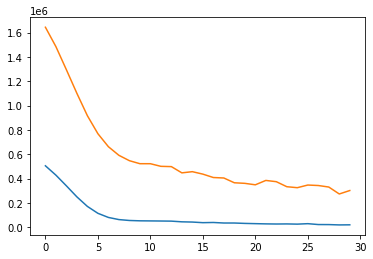

In [61]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])

In [62]:
eval_nth_set(input_data, model1, n = 1)

3/3 [==============================] - 0s 9ms/step - loss: 302206.5938


302206.59375

## Train/Test Set Number 2

In [63]:
model2, hist2 = train_nth_set(input_data, n = 2, epochs = 30)

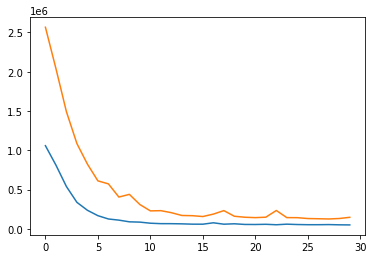

In [64]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

In [65]:
eval_nth_set(input_data, model2, n = 2)

3/3 [==============================] - 1s 5ms/step - loss: 146823.7188


146823.71875

## Train/Test Set Number 3

In [69]:
model3, hist3 = train_nth_set(input_data, n = 3, epochs = 30)

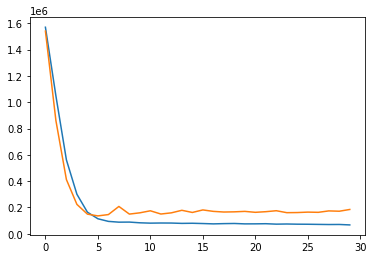

In [70]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

In [71]:
eval_nth_set(input_data, model3, n = 3)

3/3 [==============================] - 0s 3ms/step - loss: 184758.4219


184758.421875